In [3]:
# import winsound as sd
# def beep():
#     fr = 2000    # range : 37 ~ 32767
#     du = 1000     # 1000 ms ==1second
#     sd.Beep(fr, du) # winsound.Beep(frequency, duration)
# beep()

In [4]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rc
import matplotlib.pyplot as plt 
rc('font',family='Malgun Gothic') # 한글
plt.rcParams['axes.unicode_minus'] = False # 마이너스 부호

import os
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.core.display import HTML
import time
import re

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%cd /content/drive/MyDrive/Cakd3_Project/1.ldata_현정

/content/drive/MyDrive/Cakd3_Project/1.ldata_현정


In [16]:
%pwd

'/content/drive/MyDrive/Cakd3_Project/1.ldata_현정'

In [17]:
# 파일 불러와서 변수에 저장
path = './dataset'
file_list = os.listdir(path)

data_li = []
for file in file_list:
    data = pd.read_csv(f'dataset/{file}',encoding='cp949')
    file_name = file.replace('.txt','')
    globals()[file_name] = data
    data_li.append(file_name)

In [18]:
data_li

['channel', 'prodcat', 'membership', 'purprd', 'cust', 'compuse']

# 데이터 확인 및 전처리

In [19]:
# information 확인
for i in range(len(data_li)):
    print(f'============  {data_li[i]}  ============')
    print(globals()[data_li[i]].info())
    print('====================================\n')

============  channel  ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8824 entries, 0 to 8823
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   고객번호    8824 non-null   int64 
 1   제휴사     8824 non-null   object
 2   이용횟수    8824 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 206.9+ KB
None

============  prodcat  ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4386 entries, 0 to 4385
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제휴사     4386 non-null   object
 1   대분류코드   4386 non-null   int64 
 2   중분류코드   4386 non-null   int64 
 3   소분류코드   4386 non-null   object
 4   중분류명    4386 non-null   object
 5   소분류명    4386 non-null   object
dtypes: int64(2), object(4)
memory usage: 205.7+ KB
None

============  membership  ============
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7456 entries, 0 to 7455
Data columns (total

# PURPRD

In [ ]:
# purprd 구매일자 type 변경 및 년, 반기, 분기, 요일 추가
purprd['구매일자'] = pd.to_datetime(purprd['구매일자'], format='%Y%m%d')
purprd['year'] = purprd['구매일자'].dt.year
purprd['quarter'] = purprd['구매일자'].dt.quarter
purprd['weekday'] = purprd['구매일자'].dt.weekday # 월 0 ~ 일 6

def to_half(year,quarter):
    if (year==2014) & (quarter in [1,2]):
        return 1
    elif (year==2014) & (quarter in [3,4]):
        return 2
    elif (year==2015) & (quarter in [1,2]):
        return 3
    else:
        return 4
        
purprd['half'] = purprd.apply(lambda x: to_half(x['year'], x['quarter']), axis=1)

# 기존고객 적용(전체 데이터)

In [ ]:
# 기존고객 => 매 분기 1회 이상 구매한 고객으로 한정
# 기존고객만 남긴 dataframe 생성
all_cust = pd.pivot_table(purprd,
                         index='고객번호',
                         columns='half',
                         values='구매금액',
                         aggfunc='sum')

existing_cust_idx = all_cust.dropna().index.tolist() # 기존고객 고객번호

for data in data_li:
    try:
        globals()[data] = globals()[data].query(f'고객번호 == {existing_cust_idx}')
    except:
        pass

# CUST

In [ ]:
# 거주지역 숫자 -> 이름 변환 / 서울시 하나로 묶음
거주지역 = {}
with open('지역코드.txt', 'r', encoding='utf8') as f:
    for line in f:
        지역코드, 지역명 = line.strip().split('=')
        if 지역명[:2] == '서울':
            지역명 = '서울시'
        거주지역[int(지역코드)] = 지역명
        
cust['거주지역'] = cust['거주지역'].fillna(0)

def to_area(지역코드):
    if 지역코드 == 0:
        return '미기재'
    return 거주지역[int(지역코드)]

cust['거주지역'] = cust['거주지역'].apply(lambda x: to_area(x))

In [ ]:
# 연령대 묶어줌
def cat_age(age):
    if age == '19세이하':
        return 10
    elif age in ['20세~24세', '25세~29세']:
        return 20
    elif age in ['30세~34세', '35세~39세']:
        return 30
    elif age in ['40세~44세', '45세~49세']:
        return 40
    elif age in ['50세~54세', '55세~59세']:
        return 50
    else:
        return 60
    
cust['연령대'] = cust['연령대'].apply(lambda x: cat_age(x))

#  <font color=red>__종속변수__</font>

In [ ]:
# 종속변수
def to_y(df,half1,half2):
    """
    전체 매출 증감율을 고려한 고객별 매출 증감율(반기 기준)
    -> 감소고객 : 1
    -> 증가고객 : 0
    """
    sales = pd.pivot_table(df,index='고객번호', # 고객별 반기 매출
                              columns = 'half',
                              values = '구매금액',
                              aggfunc= 'sum')
    rate_variation = (sum(sales[int(half2)])-sum(sales[int(half1)]))/sum(sales[int(half1)]) # 전체 매출 증감율
    sales[f'y_{half1}_{half2}'] = (sales[int(half2)] - sales[int(half1)])/sales[int(half1)]/rate_variation # 고객별 매출 증감율
    
    def to_label(sales_variation): # 매출 감소 고객 : 1
        if sales_variation >= 0:
            return 0
        else:
            return 1
    
    sales[f'y_{half1}_{half2}'] = sales[f'y_{half1}_{half2}'].apply(lambda x: to_label(x))
    sales = sales[[f'y_{half1}_{half2}']]
    return sales.reset_index()

y = to_y(purprd, 1, 3) # lable

In [ ]:
to_y(purprd, 1, 2)

# MEMBERSHIP

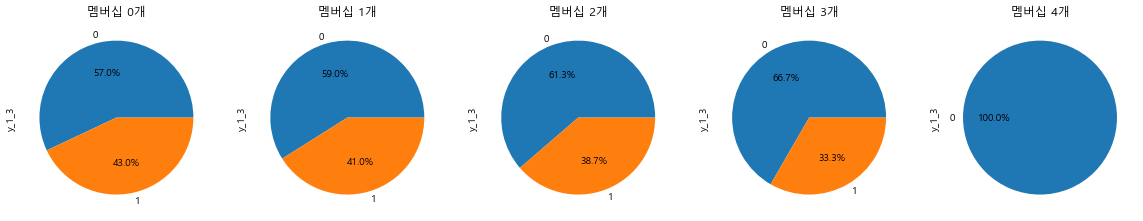

In [ ]:
# membership 가입 개수
membership_cust = pd.pivot_table(membership,
              index='고객번호',
              columns='멤버십명',
              values='가입년월',
              aggfunc='count').fillna(0)
membership_cust['가입개수'] = membership_cust.sum(axis=1)

membership_y = y.set_index('고객번호').join(membership_cust['가입개수']).fillna(0)


fig, axes = plt.subplots(1,5,figsize=(20,5))

for i in range(5):
    membership_y.query(f'가입개수=={i}')['y_1_3'].value_counts().plot(kind='pie', 
                                                                  autopct='%.1f%%',
                                                                  ax=axes[i], 
                                                                  subplots=True)
    axes[i].set_title(f'멤버십 {i}개')
    
# => membership 가입 개수가 많아질수록 구매 감소한 고객이 적음

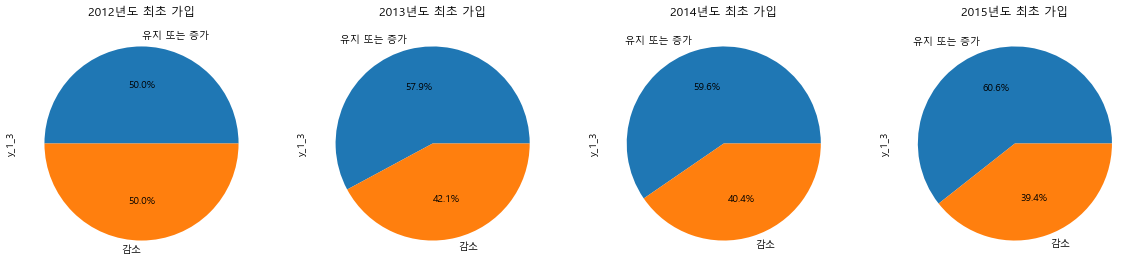

In [ ]:
# 최초 membership 가입년도
membership['가입년월'] = pd.to_datetime(membership['가입년월'], format='%Y%m')
membership['가입년도'] = membership['가입년월'].dt.year

first_membership_date = pd.pivot_table(membership,
                                index='고객번호',
                                values='가입년도',
                                aggfunc='min')

first_membership_date_y = y.set_index('고객번호').join(first_membership_date).dropna()

fig, axes = plt.subplots(1,4,figsize=(20,5))

for n,i in enumerate(range(2012,2016)):
    first_membership_date_y.query(f'가입년도=={i}')['y_1_3'].value_counts().plot(kind='pie', 
                                                                  autopct='%.1f%%',
                                                                  ax=axes[n], 
                                                                  labels=['유지 또는 증가','감소'],
                                                                  subplots=True)
    axes[n].set_title(f'{i}년도 최초 가입')

# => 멤버십 가입(최초)한지 오래될수록 구매감소 고객 증가
# 참고 : 2012년도는 6명밖에 없음 / 2013 ~ 2015년도는 2000명 안팎

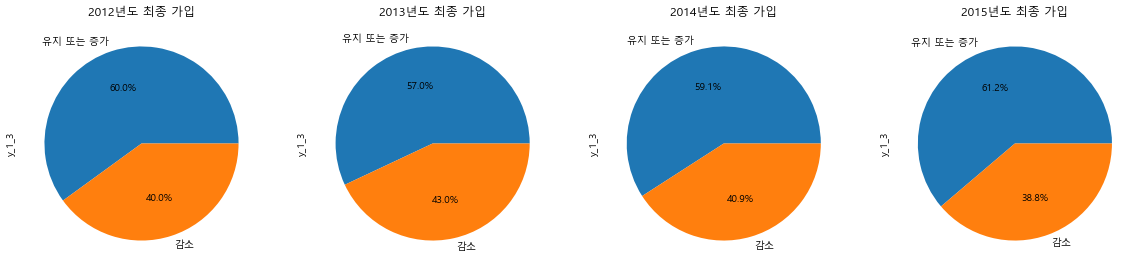

In [ ]:
# 최종 membership 가입년도
last_membership_date = pd.pivot_table(membership,
                                index='고객번호',
                                values='가입년도',
                                aggfunc='max')

last_membership_date_y = y.set_index('고객번호').join(last_membership_date).dropna()

fig, axes = plt.subplots(1,4,figsize=(20,5))

for n,i in enumerate(range(2012,2016)):
    last_membership_date_y.query(f'가입년도=={i}')['y_1_3'].value_counts().plot(kind='pie', 
                                                                  autopct='%.1f%%',
                                                                  ax=axes[n], 
                                                                  labels=['유지 또는 증가','감소'],
                                                                  subplots=True)
    axes[n].set_title(f'{i}년도 최종 가입')

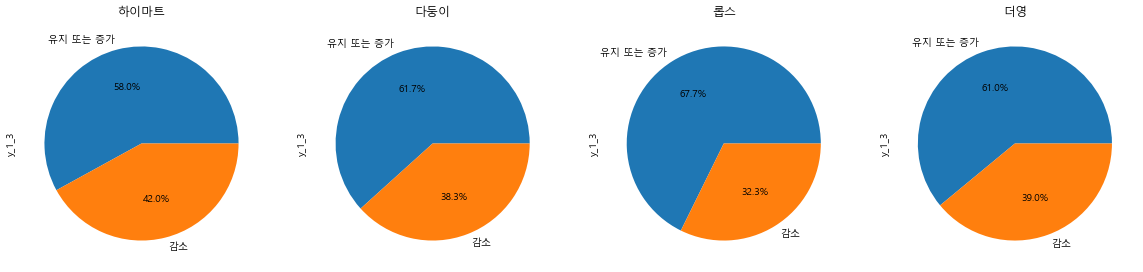

In [ ]:
# membership 종류
fig, axes = plt.subplots(1,4,figsize=(20,5))

for n, membership_name in enumerate(membership['멤버십명'].unique()):
    globals()[f'{membership_name}'] = membership.query(f'멤버십명=="{membership_name}"')
    pd.merge(globals()[f'{membership_name}'], y, on='고객번호')['y_1_3'].value_counts(1).plot(kind='pie', 
                                                                                          autopct='%.1f%%',
                                                                                          ax=axes[n], 
                                                                                          labels=['유지 또는 증가','감소'],
                                                                                          subplots=True)
    axes[n].set_title(membership_name)

# 참고 : 고객 중복 있음

In [ ]:
pd.pivot_table(membership,
               index='멤버십명',
               columns='가입년도',
               values='가입년월',
               aggfunc='count')

가입년도,2012,2013,2014,2015
멤버십명,,,,
다둥이,NaN,1081.0,613.0,303.0
더영,6.0,24.0,326.0,267.0
롭스,NaN,52.0,158.0,109.0
하이마트,NaN,999.0,1580.0,1789.0


# CHANNEL  
  
최근 3개월 데이터(2015.10 ~ 2015.12)

In [ ]:
channel_count = pd.pivot_table(channel,
              index='고객번호',
              columns='제휴사',
              values='이용횟수')

channel_count['APP로그인횟수'] = channel_count[channel_count.columns[channel_count.columns.str.contains('APP')]].sum(axis=1)
channel_count['ONLINE구매횟수'] = channel_count[channel_count.columns[channel_count.columns.str.contains('ONLINE')]].sum(axis=1)

In [ ]:
print('channel 이용자수 : ', len(channel_count))
print(' - APP, ONLINE 모두 이용 : ', len(channel_count.query('APP로그인횟수>0 & ONLINE구매횟수>0'))) # 둘 다 이용 
print(' - APP만 이용 : ', len(channel_count.query('APP로그인횟수>0 & ONLINE구매횟수==0')))
print(' - ONLINE만 이용 : ', len(channel_count.query('APP로그인횟수==0 & ONLINE구매횟수>0')))

channel 이용자수 :  6686
 - APP, ONLINE 모두 이용 :  1419
 - APP만 이용 :  4826
 - ONLINE만 이용 :  441


In [ ]:
channel_count = y.set_index('고객번호').join(channel_count)
channel_count = pd.merge(channel_count, cust, on='고객번호').fillna(0)

<AxesSubplot:title={'center':'APP, ONLINE 모두 미사용'}, ylabel='y_1_3'>

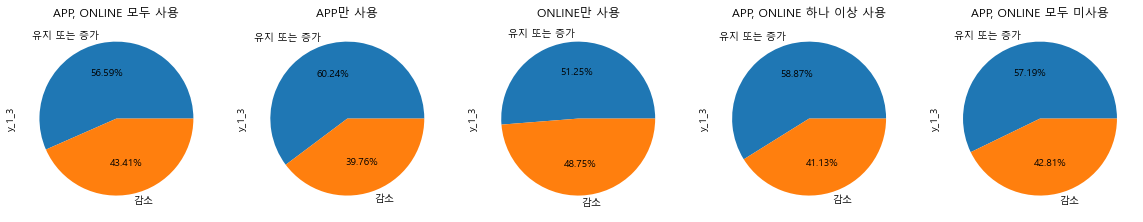

In [ ]:
# app / online 사용여부
fig, axes = plt.subplots(1,5,figsize=(20,5))

channel_count.query('APP로그인횟수>0 & ONLINE구매횟수>0')['y_1_3'].value_counts().plot(kind='pie',
                                                                             autopct='%.2f%%',
                                                                             labels=['유지 또는 증가','감소'],
                                                                             title='APP, ONLINE 모두 사용',
                                                                             ax=axes[0])

channel_count.query('APP로그인횟수>0 & ONLINE구매횟수==0')['y_1_3'].value_counts().plot(kind='pie',
                                                                             autopct='%.2f%%',
                                                                             labels=['유지 또는 증가','감소'],
                                                                             title='APP만 사용',
                                                                             ax=axes[1])

channel_count.query('APP로그인횟수==0 & ONLINE구매횟수>0')['y_1_3'].value_counts().plot(kind='pie',
                                                                             autopct='%.2f%%',
                                                                             labels=['유지 또는 증가','감소'],
                                                                             title='ONLINE만 사용',
                                                                             ax=axes[2])

channel_count.query('APP로그인횟수>0 | ONLINE구매횟수>0')['y_1_3'].value_counts().plot(kind='pie',
                                                                             autopct='%.2f%%',
                                                                             labels=['유지 또는 증가','감소'],
                                                                             title='APP, ONLINE 하나 이상 사용',
                                                                             ax=axes[3])

channel_count.query('APP로그인횟수==0 & ONLINE구매횟수==0')['y_1_3'].value_counts().plot(kind='pie',
                                                                             autopct='%.2f%%',
                                                                             labels=['유지 또는 증가','감소'],
                                                                             title='APP, ONLINE 모두 미사용',
                                                                             ax=axes[4])

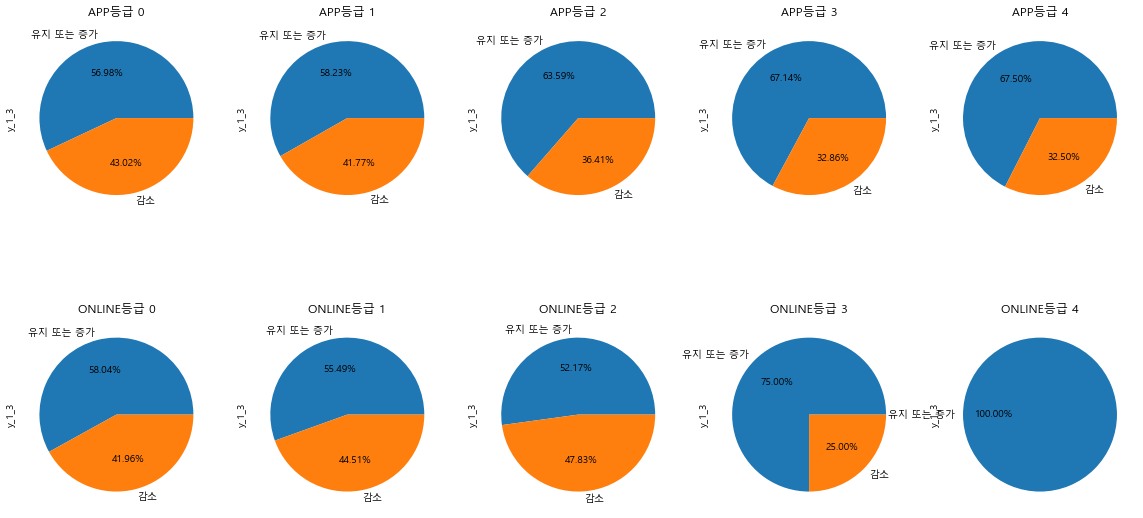

In [ ]:
def to_cat(num): # 임의로 나눔(기준 다시 정하기👻)
    if num == 0:
        return 0
    elif 0 < num < 30:
        return 1
    elif 30 <= num < 60:
        return 2
    elif 60 <= num < 90:
        return 3
    else:
        return 4
    
channel_count['APP등급'] = channel_count['APP로그인횟수'].apply(to_cat)
channel_count['ONLINE등급'] = channel_count['ONLINE구매횟수'].apply(to_cat)

fig, axes = plt.subplots(2,5,figsize=(20,10))

for n,c in enumerate(['APP','ONLINE']):
    for i in range(0, 5):
        channel_count.query(f'{c}등급=={i}')['y_1_3'].value_counts().plot(kind='pie',
                                                                   autopct='%.2f%%',
                                                                   labels=['유지 또는 증가','감소'],
                                                                   title=f'{c}등급 {i}',
                                                                   ax=axes[n,i])
        
# => APP이용자의 경우 로그인 횟수가 많은 고객일수록 감소고객이 적음
# => ONLINE이용자의 경우 구매 횟수가 어느정도까지 많아질수록 감소고객이 증가하며,
#    일정횟수 이상으로 많이 구매한 고객일수록 감소고객이 확연히 적음

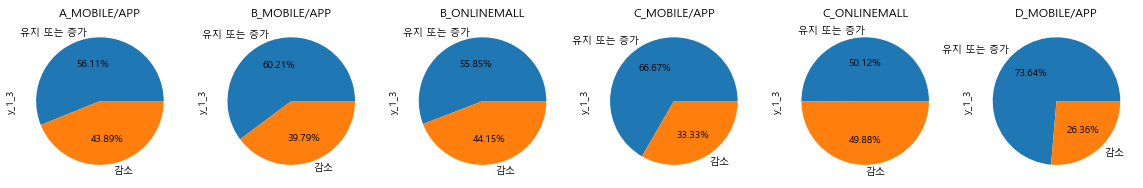

In [ ]:
# 제휴사별 channel 사용여부
fig, axes = plt.subplots(1,6,figsize=(20,5))

for n,col in enumerate(channel_count.columns[2:-7]):
    channel_user = channel_count[channel_count[col]>1]
    round(channel_user['y_1_3'].value_counts(1)*100,2).plot(kind='pie',
                                                            autopct='%.2f%%',
                                                            title=col,
                                                            labels=['유지 또는 증가','감소'],
                                                            ax=axes[n])

#### 고객 특성별 channel 이용률

In [ ]:
# 연령대 / channel(app/online)
for i in range(10, 61, 10):
    total = len(cust.query(f'연령대=={i}'))
    both = len(channel_count.query(f'APP로그인횟수>0 & ONLINE구매횟수>0 & 연령대=={i}'))
    app_only = len(channel_count.query(f'APP로그인횟수>0 & ONLINE구매횟수==0 & 연령대=={i}'))
    online_only = len(channel_count.query(f'APP로그인횟수==0 & ONLINE구매횟수>0 & 연령대=={i}'))
    
    print(f'========= {i}대 ========')
    print(' - APP, ONLINE 모두 이용 : %d 명 (%.2f%%)' % (both, both/total*100)) # 둘 다 이용 
    print(' - APP만 이용 : %d 명 (%.2f%%)' % (app_only, app_only/total*100))
    print(' - ONLINE만 이용 : %d 명 (%.2f%%)' % (online_only, online_only/total*100))

========= 10대 ========
 - APP, ONLINE 모두 이용 : 0 명 (0.00%)
 - APP만 이용 : 1 명 (7.14%)
 - ONLINE만 이용 : 0 명 (0.00%)
========= 20대 ========
 - APP, ONLINE 모두 이용 : 64 명 (7.21%)
 - APP만 이용 : 270 명 (30.41%)
 - ONLINE만 이용 : 11 명 (1.24%)
========= 30대 ========
 - APP, ONLINE 모두 이용 : 568 명 (12.88%)
 - APP만 이용 : 1416 명 (32.11%)
 - ONLINE만 이용 : 84 명 (1.90%)
========= 40대 ========
 - APP, ONLINE 모두 이용 : 558 명 (7.25%)
 - APP만 이용 : 1979 명 (25.70%)
 - ONLINE만 이용 : 227 명 (2.95%)
========= 50대 ========
 - APP, ONLINE 모두 이용 : 206 명 (4.25%)
 - APP만 이용 : 1006 명 (20.78%)
 - ONLINE만 이용 : 113 명 (2.33%)
========= 60대 ========
 - APP, ONLINE 모두 이용 : 23 명 (1.78%)
 - APP만 이용 : 154 명 (11.91%)
 - ONLINE만 이용 : 6 명 (0.46%)


In [ ]:
# 성별 / channel(app/online)
for i in ['F','M']:
    total = len(cust.query(f'성별=="{i}"'))
    both = len(channel_count.query(f'APP로그인횟수>0 & ONLINE구매횟수>0 & 성별=="{i}"'))
    app_only = len(channel_count.query(f'APP로그인횟수>0 & ONLINE구매횟수==0 & 성별=="{i}"'))
    online_only = len(channel_count.query(f'APP로그인횟수==0 & ONLINE구매횟수>0 & 성별=="{i}"'))
    
    print(f'========= {i} ========')
    print(' - APP, ONLINE 모두 이용 : %d 명 (%.2f%%)' % (both, both/total*100)) # 둘 다 이용 
    print(' - APP만 이용 : %d 명 (%.2f%%)' % (app_only, app_only/total*100))
    print(' - ONLINE만 이용 : %d 명 (%.2f%%)' % (online_only, online_only/total*100))

========= F ========
 - APP, ONLINE 모두 이용 : 1223 명 (7.77%)
 - APP만 이용 : 4013 명 (25.51%)
 - ONLINE만 이용 : 381 명 (2.42%)
========= M ========
 - APP, ONLINE 모두 이용 : 196 명 (5.74%)
 - APP만 이용 : 813 명 (23.82%)
 - ONLINE만 이용 : 60 명 (1.76%)


In [ ]:
# 거주지역 / channel(app/online)
for i in cust['거주지역'].unique():
    total = len(cust.query(f'거주지역=="{i}"'))
    both = len(channel_count.query(f'APP로그인횟수>0 & ONLINE구매횟수>0 & 거주지역=="{i}"'))
    app_only = len(channel_count.query(f'APP로그인횟수>0 & ONLINE구매횟수==0 & 거주지역=="{i}"'))
    online_only = len(channel_count.query(f'APP로그인횟수==0 & ONLINE구매횟수>0 & 거주지역=="{i}"'))
    
    print(f'========= {i} ========')
    print(' - APP, ONLINE 모두 이용 : %d 명 (%.2f%%)' % (both, both/total*100)) # 둘 다 이용 
    print(' - APP만 이용 : %d 명 (%.2f%%)' % (app_only, app_only/total*100))
    print(' - ONLINE만 이용 : %d 명 (%.2f%%)' % (online_only, online_only/total*100))

========= 서울시 ========
 - APP, ONLINE 모두 이용 : 421 명 (7.31%)
 - APP만 이용 : 1257 명 (21.83%)
 - ONLINE만 이용 : 96 명 (1.67%)
========= 경기도 ========
 - APP, ONLINE 모두 이용 : 421 명 (7.11%)
 - APP만 이용 : 1622 명 (27.38%)
 - ONLINE만 이용 : 148 명 (2.50%)
========= 강원도 ========
 - APP, ONLINE 모두 이용 : 6 명 (3.39%)
 - APP만 이용 : 52 명 (29.38%)
 - ONLINE만 이용 : 6 명 (3.39%)
========= 인천광역시 ========
 - APP, ONLINE 모두 이용 : 138 명 (12.99%)
 - APP만 이용 : 298 명 (28.06%)
 - ONLINE만 이용 : 26 명 (2.45%)
========= 부산광역시 ========
 - APP, ONLINE 모두 이용 : 142 명 (7.47%)
 - APP만 이용 : 499 명 (26.26%)
 - ONLINE만 이용 : 31 명 (1.63%)
========= 미기재 ========
 - APP, ONLINE 모두 이용 : 6 명 (3.68%)
 - APP만 이용 : 36 명 (22.09%)
 - ONLINE만 이용 : 6 명 (3.68%)
========= 울산광역시 ========
 - APP, ONLINE 모두 이용 : 6 명 (2.79%)
 - APP만 이용 : 58 명 (26.98%)
 - ONLINE만 이용 : 4 명 (1.86%)
========= 경상북도 ========
 - APP, ONLINE 모두 이용 : 14 명 (4.18%)
 - APP만 이용 : 78 명 (23.28%)
 - ONLINE만 이용 : 14 명 (4.18%)
========= 대구광역시 ========
 - APP, ONLINE 모두 이용 : 14 명 (4.42%)
 - APP

# COMPUSE

In [ ]:
compuse_count = pd.pivot_table(compuse,
                index='고객번호',
                columns='경쟁사',
                values='제휴사',
                aggfunc='count').fillna(0)

compuse_count['c_A'] = compuse_count['A01'] + compuse_count['A02']
compuse_count['c_B'] = compuse_count['B01'] + compuse_count['B02']
compuse_count['c_C'] = compuse_count['C01'] + compuse_count['C02'] + compuse_count['C03']
compuse_count['c_D'] = compuse_count['D01'] + compuse_count['D02']
compuse_count['c_total'] = compuse_count['c_A'] + compuse_count['c_B'] + compuse_count['c_C'] + compuse_count['c_D']

compuse_count = y.set_index('고객번호').join(compuse_count).fillna(0)

In [ ]:
purprd_count = pd.pivot_table(purprd.drop_duplicates(subset='영수증번호'),
                              index='고객번호',
                              columns='제휴사',
                              values='영수증번호',
                              aggfunc='count').fillna(0)
purprd_count['total'] = purprd_count.sum(axis=1)

compuse_count = compuse_count.join(purprd_count)

for name in ['A','B','C','D','total']:
    compuse_count[f'c_{name}_rate'] = round(compuse_count[f'c_{name}']/(compuse_count[f'c_{name}']+compuse_count[f'{name}'])*100, 2)
    
compuse_count.fillna(200, inplace=True) # 당사, 경쟁사 둘 다 이용 안한 경우

In [ ]:
def rate_cat(rate): # 임의로 나눔(기준 다시 정하기👻) 
    if rate == 0:
        return 0
    elif 0 < rate <= 20:
        return 1
    elif 20 < rate <= 40:
        return 2
    elif 40 < rate <= 60:
        return 3
    elif 60 < rate <= 80:
        return 4
    elif 80 < rate <= 100:
        return 5
    elif rate == 200:
        return 6
    
for name in ['A','B','C','D']:
    compuse_count[f'c_{name}등급'] = compuse_count[f'c_{name}_rate'].apply(rate_cat)

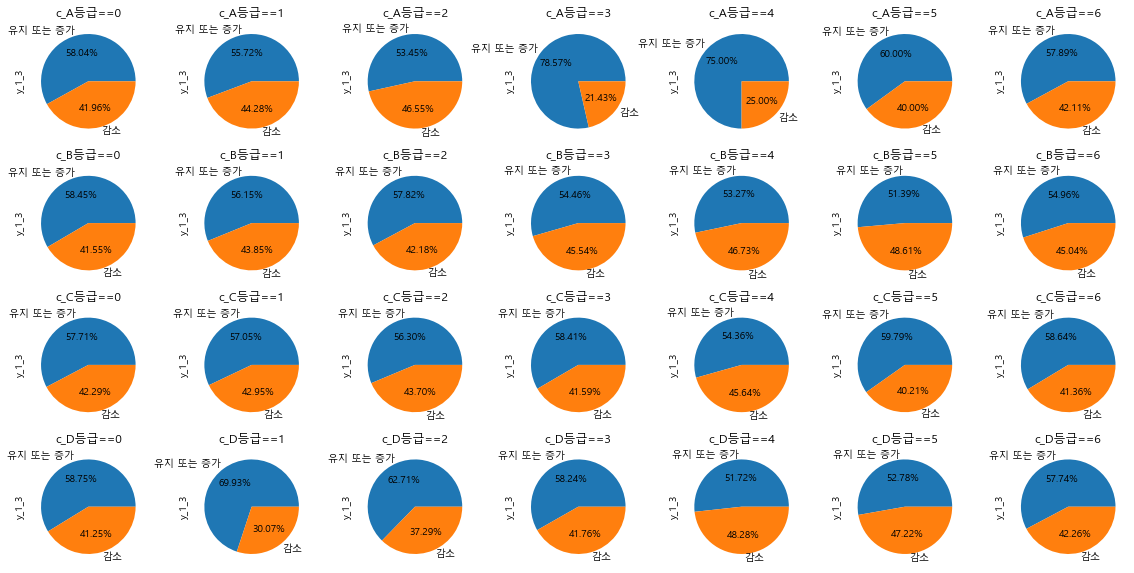

In [ ]:
fig, axes = plt.subplots(4, 7,figsize=(20,10))

for n,name in enumerate(['A','B','C','D']):
    for i in range(0, 7):
        compuse_count.query(f'c_{name}등급=={i}')['y_1_3'].value_counts().plot(kind='pie',
                                                                   autopct='%.2f%%',
                                                                   labels=['유지 또는 증가','감소'],
                                                                   title=f'c_{name}등급=={i}',
                                                                   ax=axes[n,i])
        
# => B, D 경쟁사를 이용한 고객의 경우 경쟁사 이용률 %가 높아질수록 감소고객 증가한 것 같음

In [ ]:
compuse['이용년월'] = pd.to_datetime(compuse['이용년월'], format='%Y%m')
compuse['월'] = compuse['이용년월'].dt.month

compuse_month = pd.pivot_table(compuse,
              index='고객번호',
              columns='월',
              values='제휴사',
              aggfunc='count').fillna(0)

compuse_month['상반기'] = compuse_month[list(range(1,7))].sum(axis=1)
compuse_month['하반기'] = compuse_month[list(range(7,13))].sum(axis=1)

In [ ]:
def compare(상반기, 하반기):
    if 상반기 < 하반기:
        return '증가'
    elif 상반기 == 하반기:
        return '동일'
    else:
        return '감소'
    
compuse_month['변동'] = compuse_month.apply(lambda x: compare(x['상반기'], x['하반기']), axis=1)

compuse_month = y.set_index('고객번호').join(compuse_month)
compuse_month.fillna('미이용', inplace=True)

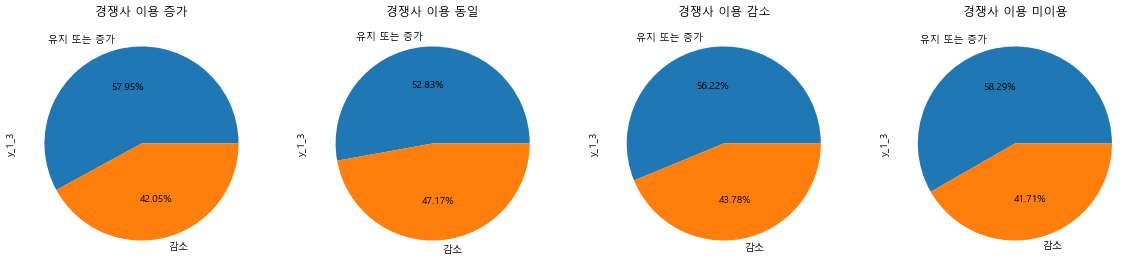

In [ ]:
# 2015년 상반기/하반기 이용횟수 증가/동일/감소/미이용
fig, axes = plt.subplots(1, 4,figsize=(20,10))

for n,i in enumerate(['증가','동일','감소','미이용']):
    compuse_month.query(f'변동=="{i}"')['y_1_3'].value_counts().plot(kind='pie',
                                                                   autopct='%.2f%%',
                                                                   labels=['유지 또는 증가','감소'],
                                                                   title=f'경쟁사 이용 {i}',
                                                                   ax=axes[n])

# CUST

In [ ]:
cust_y = pd.merge(y, cust, on='고객번호')

In [ ]:
def get_pie(df, col):
    df1 = df.copy()
    num = len(df1[col].unique())
    fig, axes = plt.subplots(1, num,figsize=(20,10))
    
    if df1[[col]].dtypes[0] != 'object':
        df1[col] = df1[col].astype('str')
    
    col_li = sorted(list(df[col].unique()))
    for n,i in enumerate(col_li):
        df1.query(f'{col}=="{i}"')['y_1_3'].value_counts().plot(kind='pie',
                                                               autopct='%.2f%%',
                                                               labels=['유지 또는 증가','감소'],
                                                               title=f'{col}_{i}',
                                                               ax=axes[n])

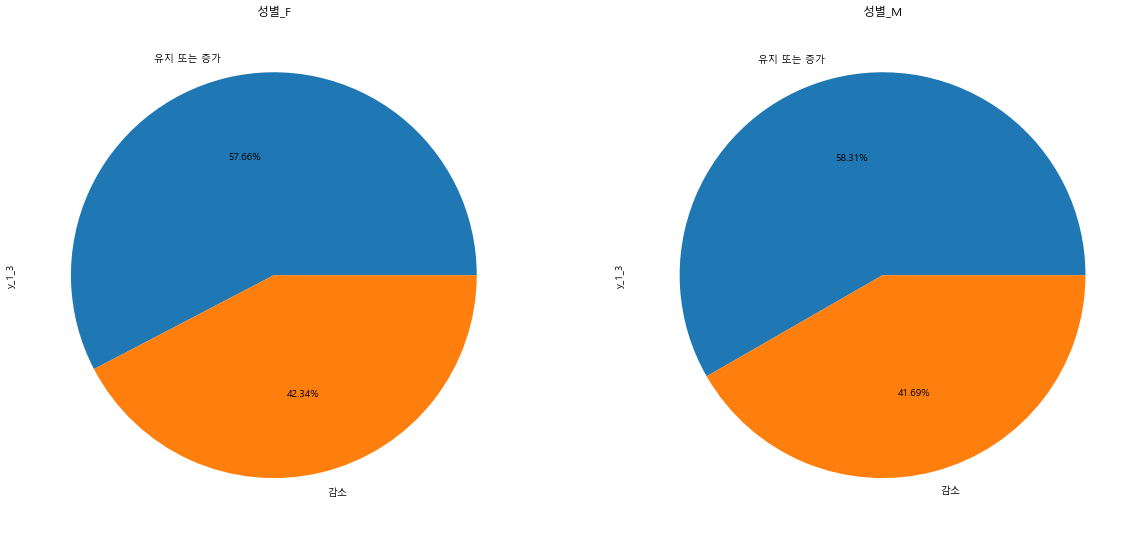

In [ ]:
get_pie(cust_y, '성별')

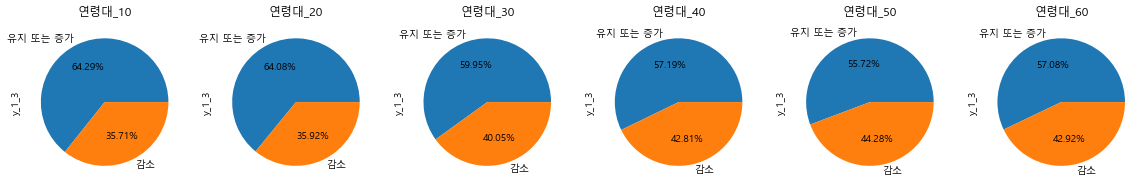

In [ ]:
get_pie(cust_y, '연령대')

# PRODCAT

In [ ]:
# 상품분류 - 대분류, 구매목적분류 추가(수작업)
cat_name = pd.read_excel('상품분류.xlsx', index_col=0)[['소분류코드','대분류','구매목적분류']]
prodcat = pd.merge(prodcat, cat_name, on=['소분류코드'])

In [ ]:
purprd = pd.merge(purprd, prodcat[['소분류코드','중분류명','소분류명','대분류','구매목적분류']])

# PURPRD_비중

In [ ]:
# 불필요한 컬럼 제거
purprd.drop(['대분류코드','중분류코드','소분류코드'], axis=1, inplace=True)

#### 구매목적분류

In [ ]:
def to_rate(df, name):
    total = df.sum(axis=1)
    for col in df.columns:
        df[f'{col}_{name}_rate'] = round(df[col]/total*100, 2)
        df.drop(col, axis=1, inplace=True)
    return df

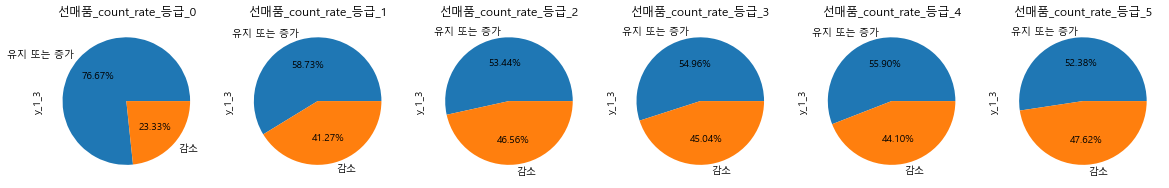

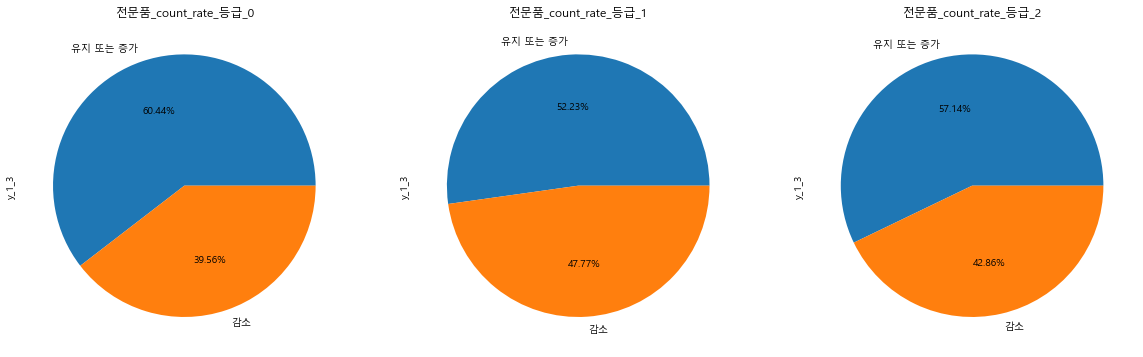

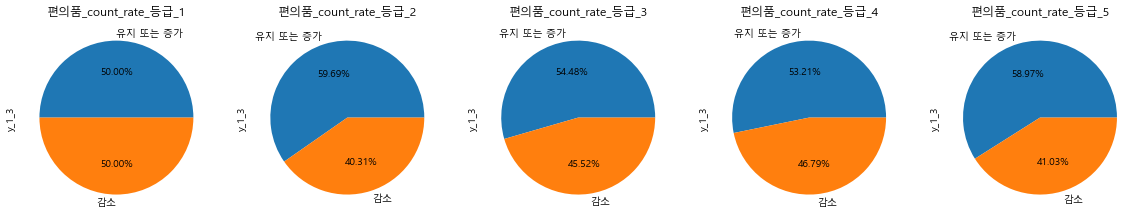

In [ ]:
# 구매목적분류별 구매횟수에 따른 구매증가/감소고객 비율
purpose_cat_count = pd.pivot_table(purprd.query('half==[1,2]'),
                                  index='고객번호',
                                  columns='구매목적분류',
                                  values='구매금액',
                                  aggfunc='count').fillna(0)
to_rate(purpose_cat_count, 'count')
purpose_cat_count = y.set_index('고객번호').join(purpose_cat_count)

for col in purpose_cat_count.columns[1:]:
    purpose_cat_count[f'{col}_등급'] = purpose_cat_count[col].apply(rate_cat)
    
for col in purpose_cat_count.columns[4:]:
    get_pie(purpose_cat_count, col)

In [ ]:
# 구매목적분류별 구매금액에 따른 구매증가/감소고객 비율
purpose_cat_sum = pd.pivot_table(purprd.query('half==[1,2]'),
                                  index='고객번호',
                                  columns='구매목적분류',
                                  values='구매금액',
                                  aggfunc='sum').fillna(0)
to_rate(purpose_cat_sum, 'sum')
purpose_cat_sum = y.set_index('고객번호').join(purpose_cat_sum)

for col in purpose_cat_sum.columns[1:]:
    purpose_cat_sum[f'{col}_등급'] = purpose_cat_sum[col].apply(rate_cat)

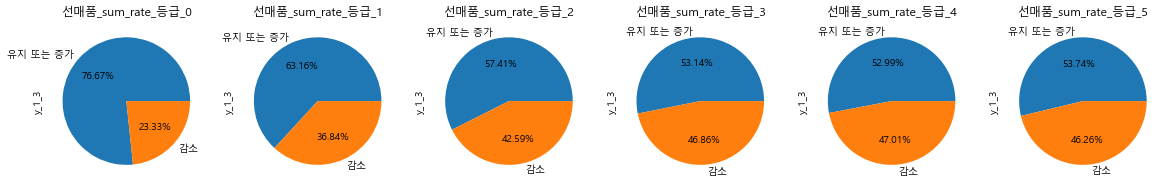

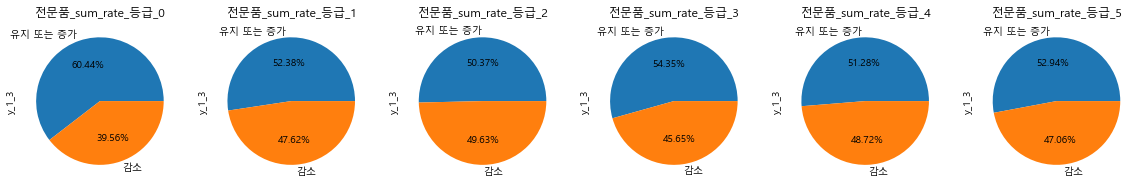

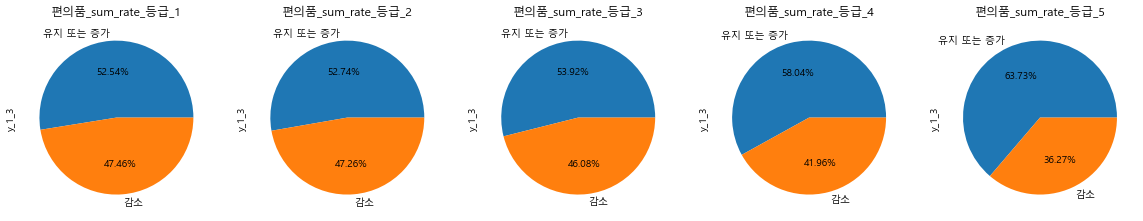

In [ ]:
for col in purpose_cat_sum.columns[4:]:
    get_pie(purpose_cat_sum, col)

#### 대분류

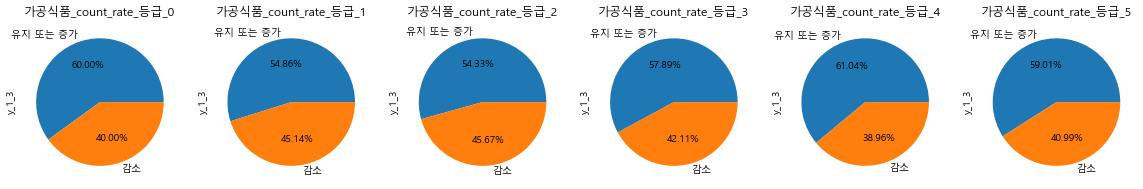

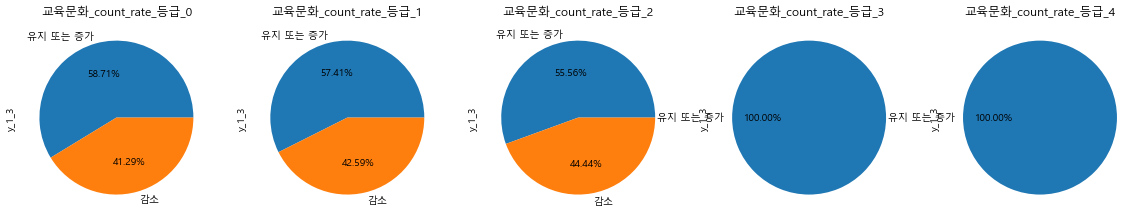

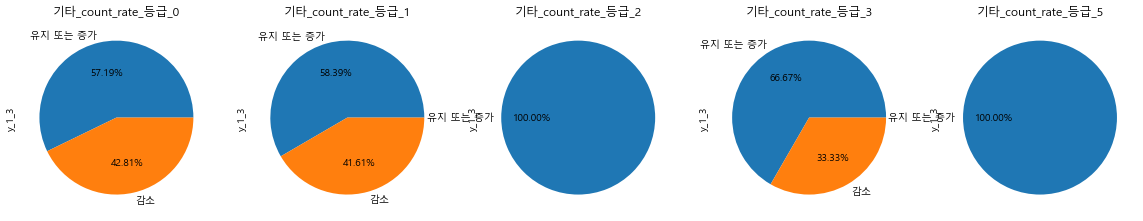

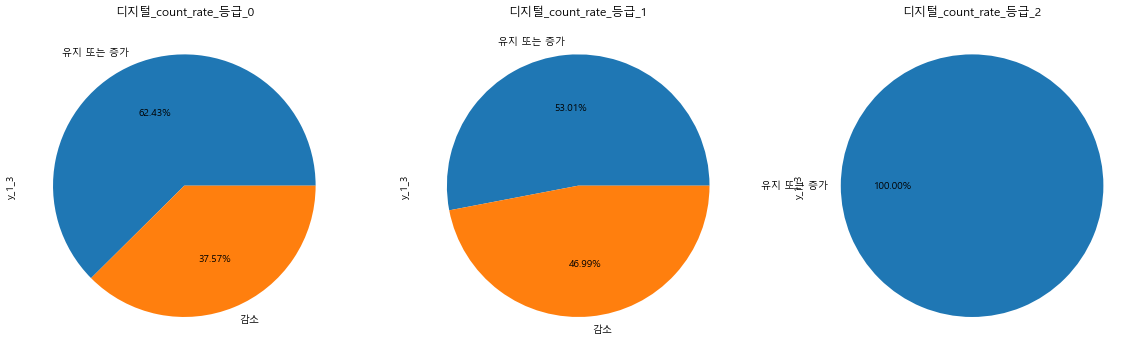

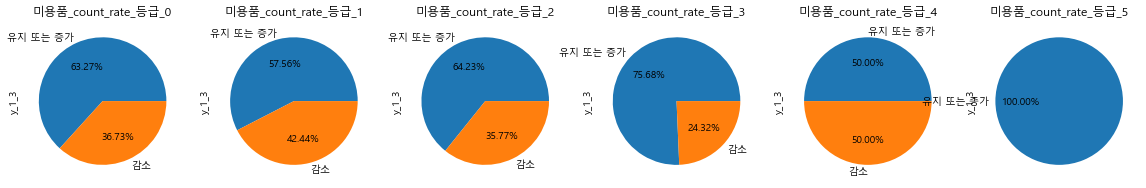

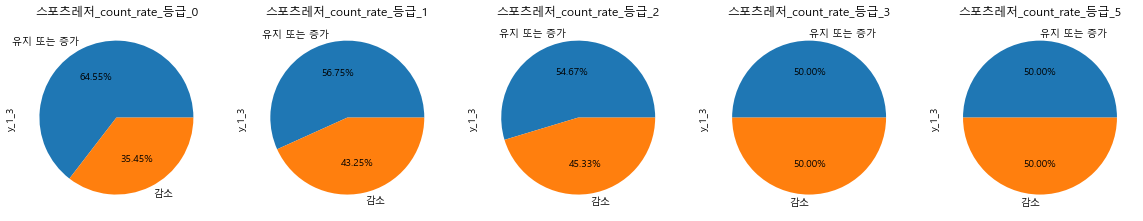

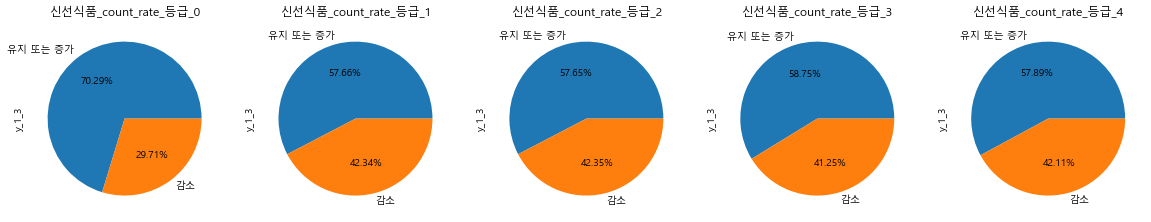

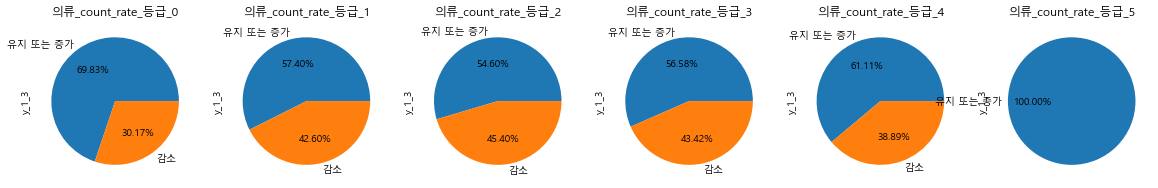

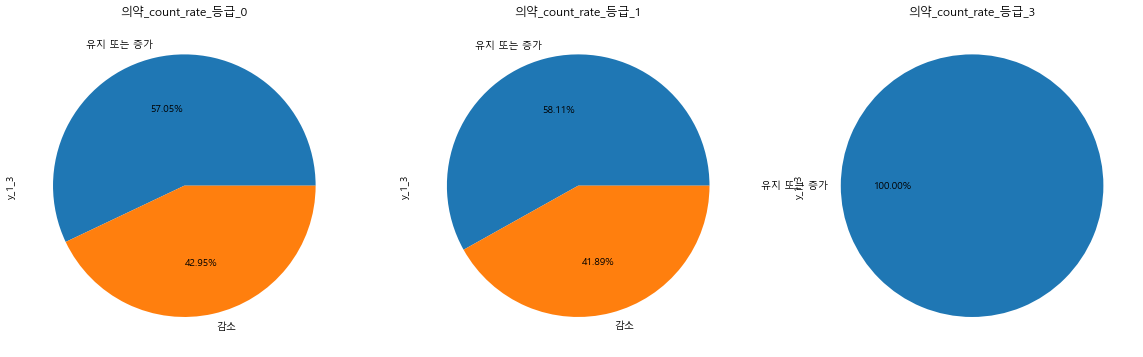

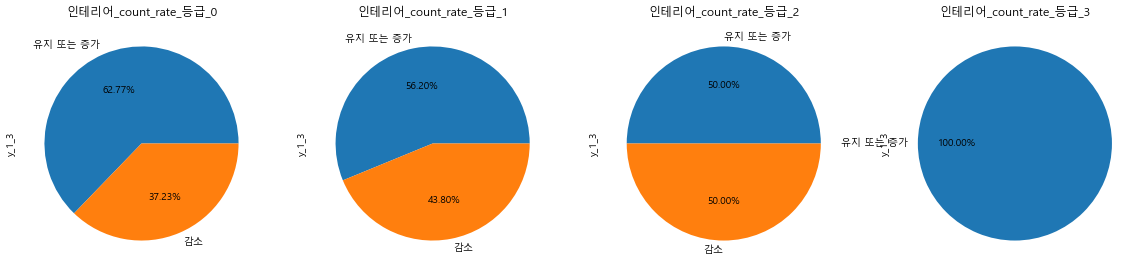

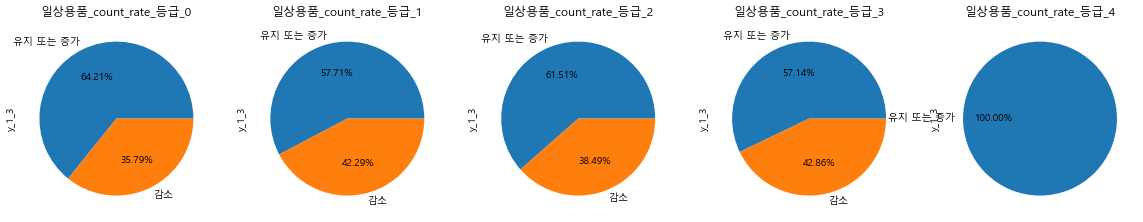

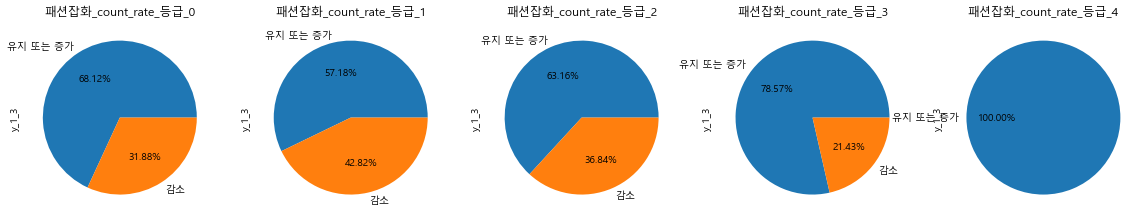

In [ ]:
# 대분류별 구매횟수에 따른 구매증가/감소고객 비율
major_cat_count = pd.pivot_table(purprd.query('half==[1,2]'),
                                  index='고객번호',
                                  columns='대분류',
                                  values='구매금액',
                                  aggfunc='count').fillna(0)

to_rate(major_cat_count, 'count')
major_cat_count = y.set_index('고객번호').join(major_cat_count)

for col in major_cat_count.columns[1:]:
    major_cat_count[f'{col}_등급'] = major_cat_count[col].apply(rate_cat)
    
for col in major_cat_count.columns[-12:]:
    get_pie(major_cat_count, col)

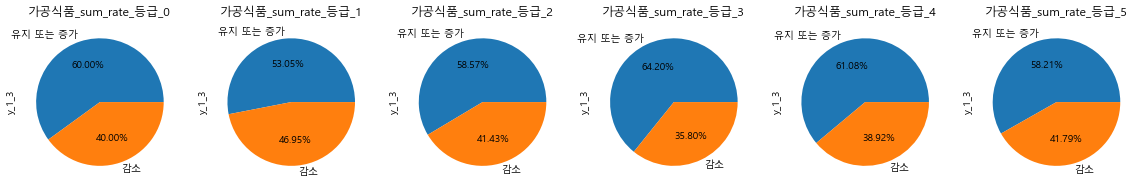

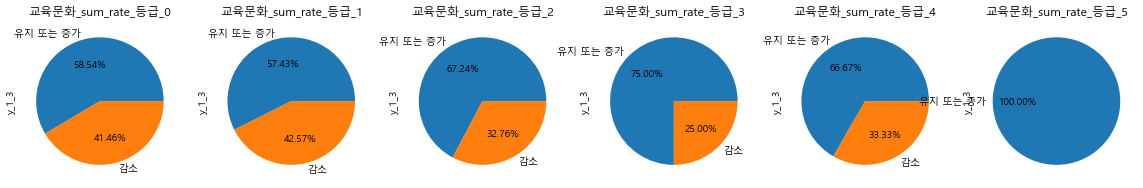

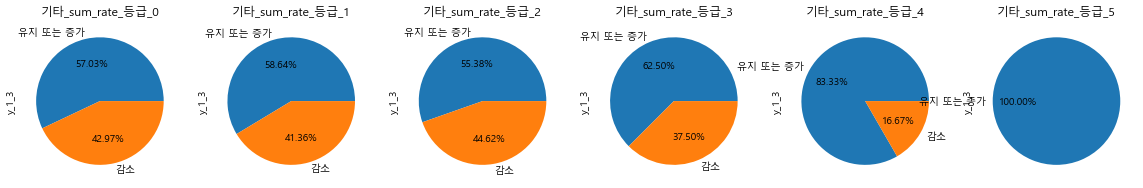

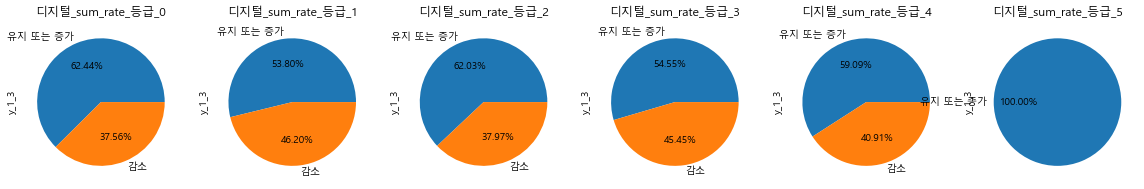

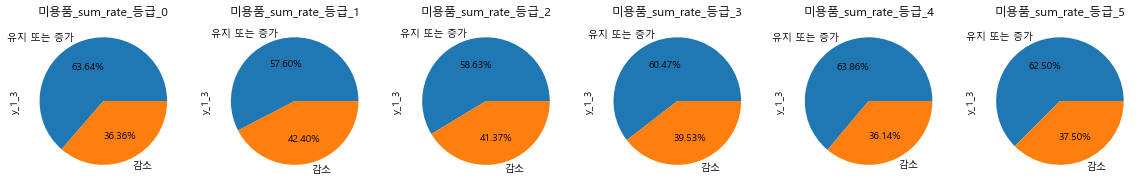

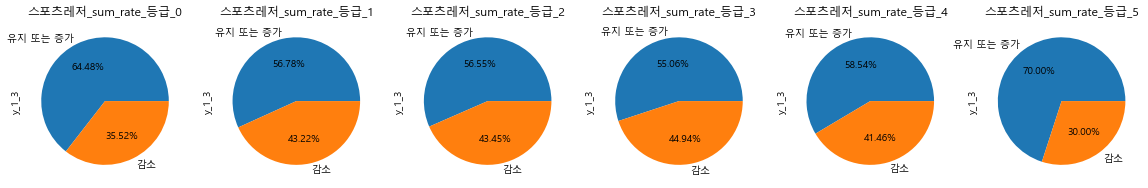

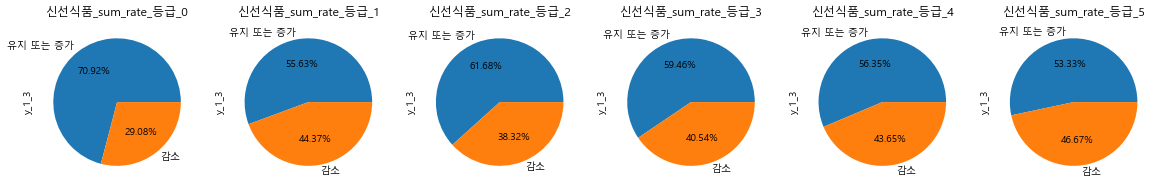

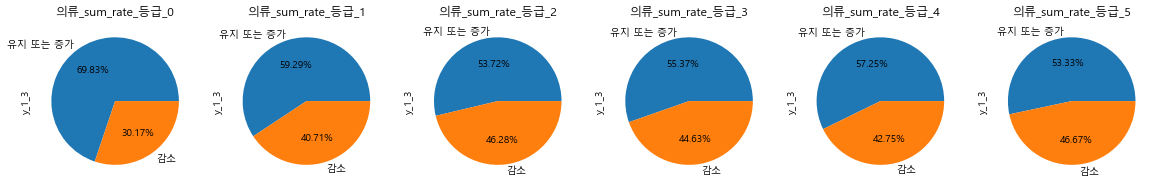

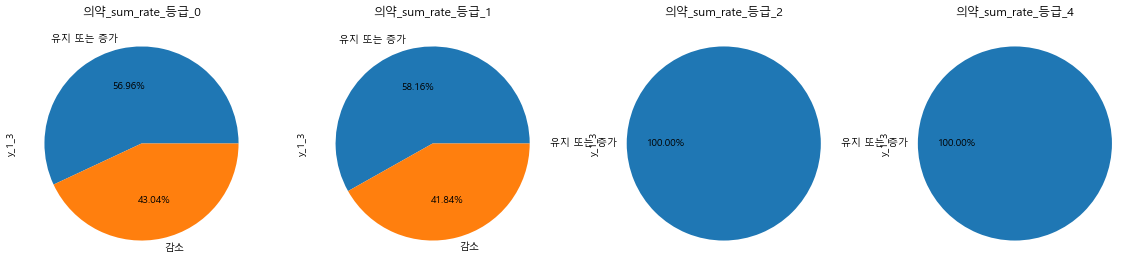

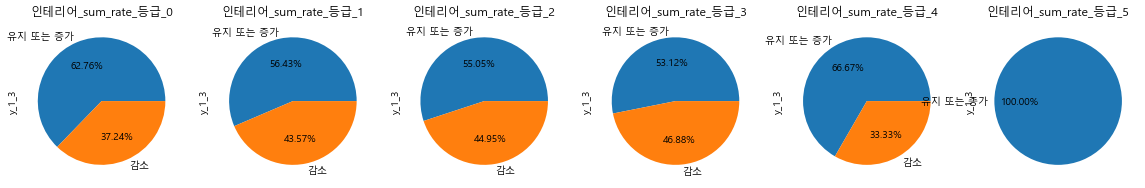

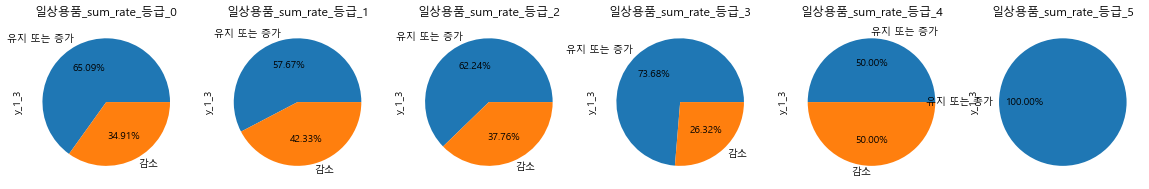

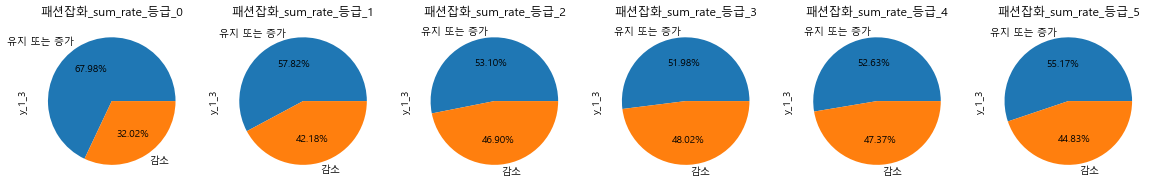

In [ ]:
# 대분류별 구매금액에 따른 구매증가/감소고객 비율
major_cat_sum = pd.pivot_table(purprd.query('half==[1,2]'),
                                  index='고객번호',
                                  columns='대분류',
                                  values='구매금액',
                                  aggfunc='sum').fillna(0)
to_rate(major_cat_sum, 'sum')
major_cat_sum = y.set_index('고객번호').join(major_cat_sum)

for col in major_cat_sum.columns[1:]:
    major_cat_sum[f'{col}_등급'] = major_cat_sum[col].apply(rate_cat)
    
for col in major_cat_sum.columns[-12:]:
    get_pie(major_cat_sum, col)

#### 제휴사

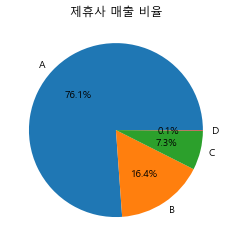

In [ ]:
# 제휴사별 매출 비율
plt.pie(purprd.groupby('제휴사')['구매금액'].sum(), labels=purprd.groupby('제휴사')['구매금액'].sum().index, autopct='%.1f%%')
plt.title('제휴사 매출 비율')
plt.show()

In [ ]:
h_sales = pd.pivot_table(purprd,
                        index='제휴사',
                        columns='half',
                        values='구매금액',
                        aggfunc='sum')

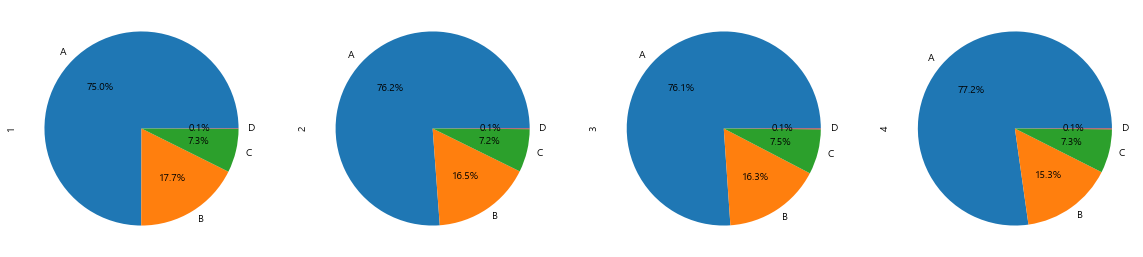

In [ ]:
# 반기별 제휴사 매출 비율
fig, axes = plt.subplots(1,4,figsize=(20,5))

for n, col in enumerate(h_sales.columns):
    h_sales[col].plot(kind='pie', labels=h_sales.index, autopct='%.1f%%', ax=axes[n])

In [ ]:
round(h_sales/h_sales.sum()*100, 2)

half,1,2,3,4
제휴사,,,,
A,74.95,76.17,76.09,77.23
B,17.71,16.55,16.27,15.34
C,7.27,7.17,7.50,7.29
D,0.07,0.11,0.14,0.13


<BarContainer object of 4 artists>

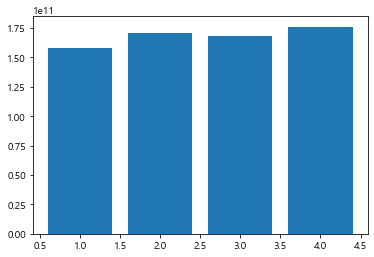

In [ ]:
# 반기별 전체 매출
plt.bar(h_sales.sum().index, h_sales.sum())

# ===> 전체 매출 상승세

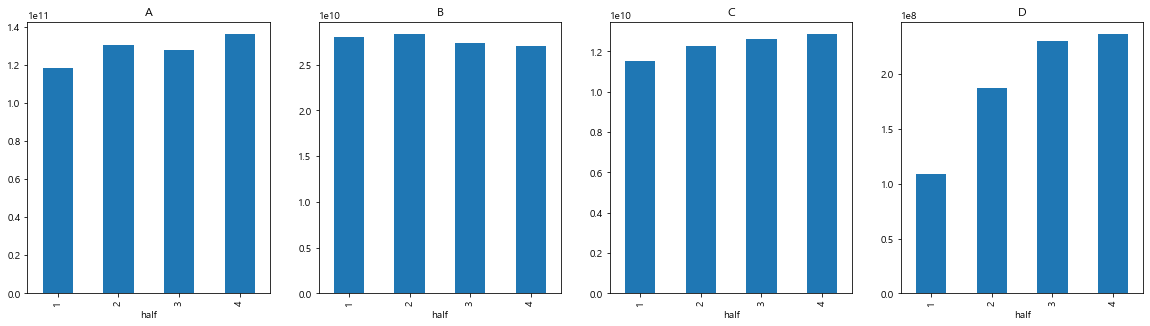

In [ ]:
# 반기별 제휴사 매출
fig, axes = plt.subplots(1,4,figsize=(20,5))

for n, idx in enumerate(h_sales.index):
    h_sales.T[idx].plot(kind='bar', ax=axes[n], title=idx)
    

# ===> B 제휴사 매출 하락세
# ===> D 제휴사(13년도 시작한 신생 사업)는 사업 확장으로 인한 매출 상승세로 추측됨

<BarContainer object of 4 artists>

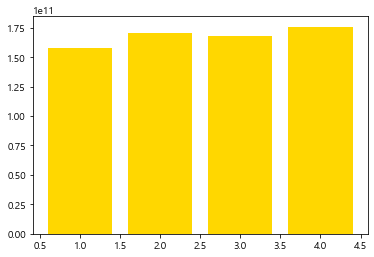

In [ ]:
# D 제휴사를 제외한 전체 매출
plt.bar(h_sales.drop('D').sum().index, h_sales.drop('D').sum(), color='gold')

In [ ]:
# 증감율 계산(기간 입력)
def variation(df, period_1, period_2):
    variation = round((df[period_2]-df[period_1])/df[period_1]*100,2)
    return pd.DataFrame(variation)

In [ ]:
# 증감율 계산
def variation_df(df):
    for n, col in enumerate(df.columns[:-1]):
        variation = pd.Series((df[col+1]-df[col])/df[col]*100, name=col+1).round(2)
        if n==0:
            variation_df = variation
        else:
            variation_df = pd.concat([variation_df, variation], axis=1)
    variation_df
    return variation_df

variation_df(h_sales)

,2,3,4
제휴사,,,
A,9.86,-1.65,6.20
B,1.03,-3.18,-1.35
C,6.50,3.00,1.71
D,71.81,22.88,2.68


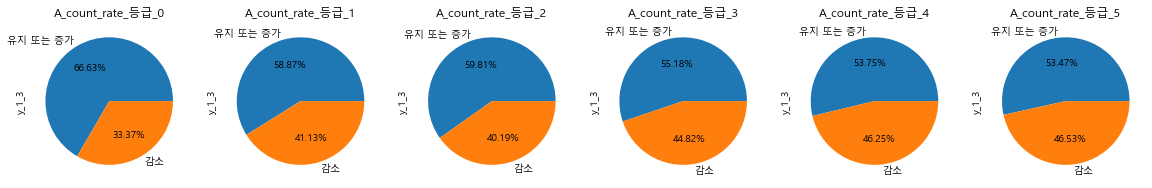

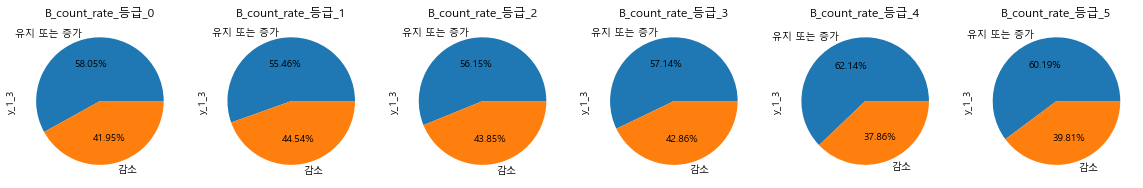

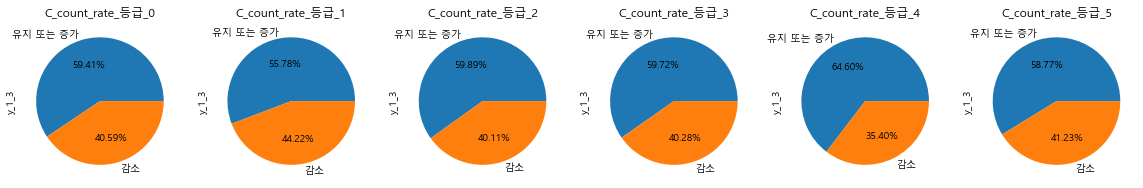

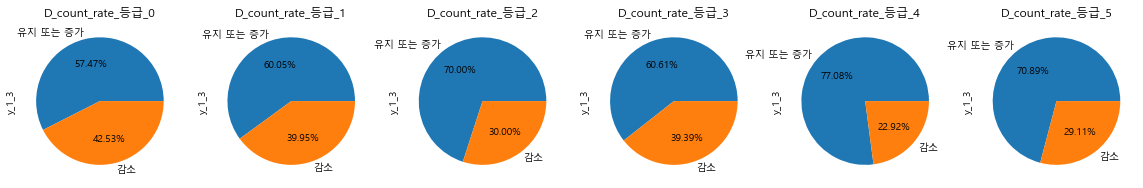

In [ ]:
# 제휴사별 구매횟수에 따른 구매증가/감소고객 비율
affiliate_count = pd.pivot_table(purprd.query('half==[1,2]'),
                                  index='고객번호',
                                  columns='제휴사',
                                  values='구매금액',
                                  aggfunc='count').fillna(0)

to_rate(affiliate_count, 'count')
affiliate_count = y.set_index('고객번호').join(affiliate_count)

for col in affiliate_count.columns[1:]:
    affiliate_count[f'{col}_등급'] = affiliate_count[col].apply(rate_cat)
    
for col in affiliate_count.columns[5:]:
    get_pie(affiliate_count, col)

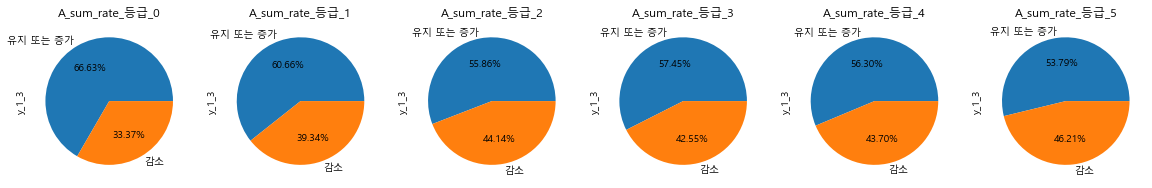

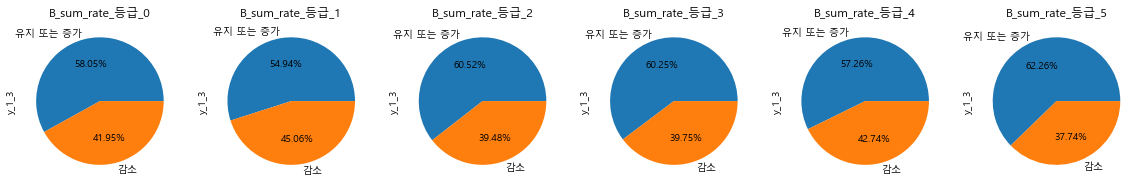

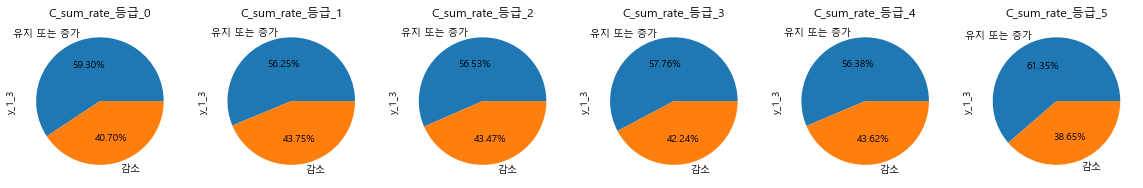

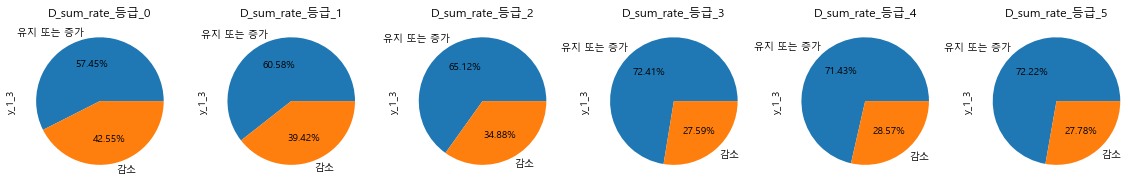

In [ ]:
# # 제휴사별 구매금액에 따른 구매증가/감소고객 비율
affiliate_sum = pd.pivot_table(purprd.query('half==[1,2]'),
                                  index='고객번호',
                                  columns='제휴사',
                                  values='구매금액',
                                  aggfunc='sum').fillna(0)
to_rate(affiliate_sum, 'sum')
affiliate_sum = y.set_index('고객번호').join(affiliate_sum)

for col in affiliate_sum.columns[1:]:
    affiliate_sum[f'{col}_등급'] = affiliate_sum[col].apply(rate_cat)
    
for col in affiliate_sum.columns[5:]:
    get_pie(affiliate_sum, col)

#### 구매일자(요일)

In [ ]:
def weekday(day):
    if day in [0,1,2,3,4]:
        return '평일'
    elif day in [5,6]:
        return '주말'
    
purprd['요일'] = purprd['weekday'].apply(weekday)

In [ ]:
weekdays = pd.pivot_table(purprd.drop_duplicates(subset='영수증번호'),
              index='고객번호',
              columns='요일',
              values='영수증번호',
              aggfunc='count')

to_rate(weekdays, '')
weekdays = y.set_index('고객번호').join(weekdays)

for col in weekdays.columns[1:]:
    weekdays[f'{col}_등급'] = weekdays[col].apply(rate_cat)

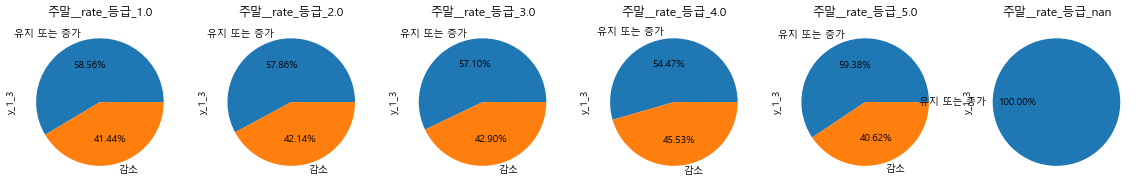

In [ ]:
get_pie(weekdays, '주말__rate_등급')

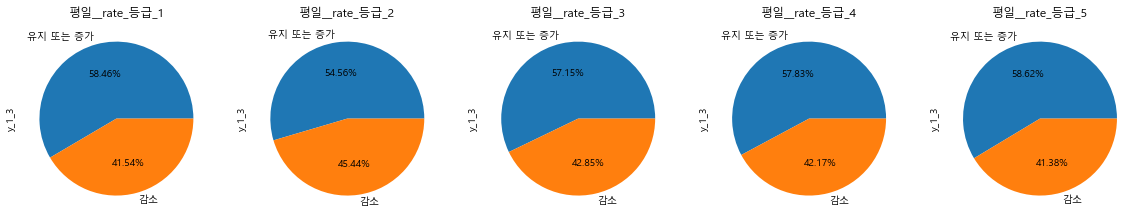

In [ ]:
get_pie(weekdays, '평일__rate_등급')

# PURPRD_증감율

In [ ]:
purprd.head(1)

,제휴사,영수증번호,고객번호,점포코드,구매일자,구매시간,구매금액,year,quarter,weekday,half,중분류명,소분류명,대분류,구매목적분류,요일
0,B,8664000,17218,44,2014-02-22,20,2420,2014,1,5,1,탄산음료,사이다,가공식품,편의품,주말


In [ ]:
# 증감율 계산(purprd, 구매금액 기준)
def purprd_amount_pv(df, col, period1, period2):
    for i in [period1, period2]:
        globals()[f'p{i}'] = pd.pivot_table(purprd.query(f'half=={i}'),
                                           index='고객번호',
                                           columns=col,
                                           values='구매금액',
                                           aggfunc='sum').fillna(0)
        
    variation = (globals()[f'p{period2}'] - globals()[f'p{period1}'])/globals()[f'p{period1}']
    return variation.replace({np.inf:1, np.nan:0})

In [ ]:
# 종속변수 상관계수 확인하기 위해 0,1 변환 전 증감율까지만 계산
def y_test(df,half1,half2):
    sales = pd.pivot_table(df,index='고객번호', # 고객별 반기 매출
                              columns = 'half',
                              values = '구매금액',
                              aggfunc= 'sum')
    rate_variation = (sum(sales[int(half2)])-sum(sales[int(half1)]))/sum(sales[int(half1)]) # 전체 매출 증감율
    sales[f'y_{half1}_{half2}'] = (sales[int(half2)] - sales[int(half1)])/sales[int(half1)]/rate_variation # 고객별 매출 증감율
    
    sales = sales[[f'y_{half1}_{half2}']]
    return sales.reset_index()

yy = y_test(purprd, 1, 3)

<AxesSubplot:>

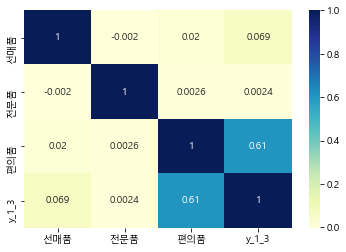

In [ ]:
sns.heatmap(purprd_amount_pv(purprd, '구매목적분류', 1, 2).join(yy.set_index('고객번호')).corr(),
           annot=True,cmap='YlGnBu')

# => 편의품 반기별 구매금액 증감율과 구매금액 증감율 상관계수 높음

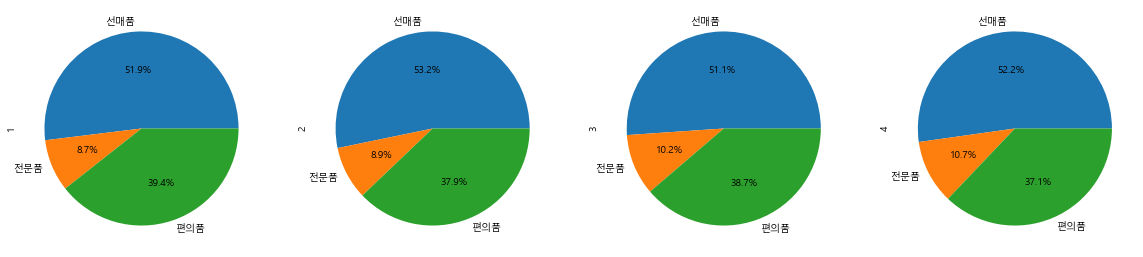

In [ ]:
# 구매목적분류별 구매금액 비중(반기별)
pv_1 = pd.pivot_table(purprd,
              index='구매목적분류',
              columns='half',
              values='구매금액',
              aggfunc='sum')

fig, axes = plt.subplots(1,4,figsize=(20,5))

for n, col in enumerate(pv_1.columns):
    pv_1[col].plot(kind='pie', labels=pv_1.index, autopct='%.1f%%', ax=axes[n])

<AxesSubplot:>

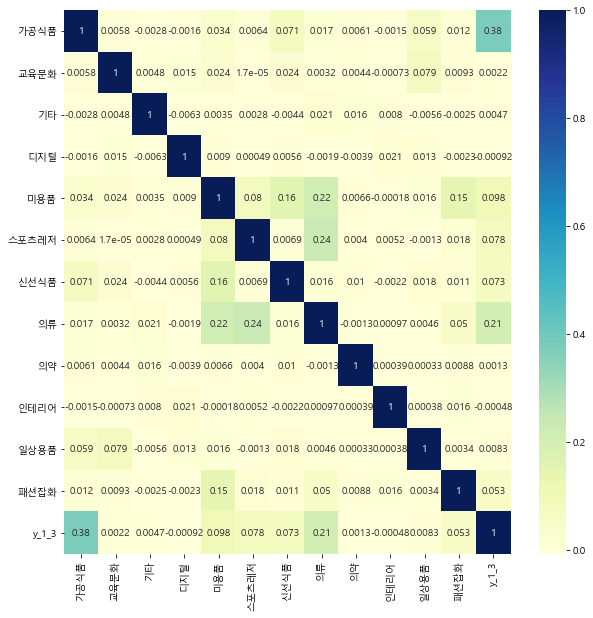

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(purprd_amount_pv(purprd, '대분류', 1, 2).join(yy.set_index('고객번호')).corr(),
           annot=True,cmap='YlGnBu')

<AxesSubplot:>

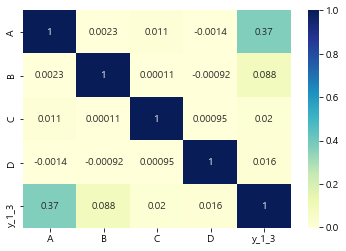

In [ ]:
sns.heatmap(purprd_amount_pv(purprd, '제휴사', 1, 2).join(yy.set_index('고객번호')).corr(),
           annot=True,cmap='YlGnBu')

<AxesSubplot:>

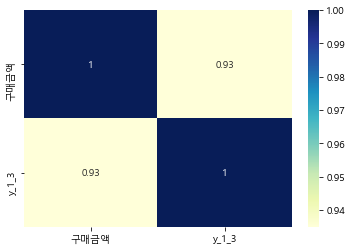

In [ ]:
sns.heatmap(purprd_amount_pv(purprd, None, 1, 2).join(yy.set_index('고객번호')).corr(),
           annot=True,cmap='YlGnBu') # 1, 2반기 구매금액 증감율